In [1]:
import pickle

import matplotlib.pyplot as plt
from matplotlib import collections as mc
import numpy as np
import sklearn
from sklearn import linear_model
import torch

import os
os.chdir('..')

from latent_actions.cvae.cvae import ConditionalVAE
from latent_actions.envs.panda_center_out import PandaCenterOutEnv

In [2]:
with open('data/demonstration_center_out_uniform_action.pkl', 'rb') as fp:
    episodes = pickle.load(fp)

In [3]:
env = PandaCenterOutEnv(render=False, control_type='ee')

# Enumerate the goals

goals = set()

while len(goals) != 8:
    obs = env.reset()
    goals.add(tuple(obs['desired_goal']))
    
goals = sorted(list(goals), key=lambda g: (-g[1], g[0]))

neutral_ee_position = obs['achieved_goal']
neutral_joint_angles = np.array([env.robot.get_joint_angle(i) for i in range(10)])

# Enumerate the joint angles for each goal

joint_angles_at_goals = []

for goal in goals:
    while tuple(env._get_obs()['desired_goal']) != goal:
        obs = env.reset()
    
    is_success = False
    while not is_success:
        a = obs['desired_goal'] - obs['achieved_goal']
        obs, _, _, info = env.step(a)
        is_success = info['is_success']
        
    joint_angles = np.array([env.robot.get_joint_angle(i) for i in range(10)])
    joint_angles_at_goals.append(joint_angles)

In [4]:
joint_angles_at_goals

[array([ 1.44588306e-01,  1.56268346e-01,  8.07866432e-02, -2.22773083e+00,
        -1.82527290e-02,  2.38333390e+00,  1.02300393e+00,  0.00000000e+00,
         0.00000000e+00,  4.39487283e-08]),
 array([ 1.19207576e-01,  4.28402138e-01,  4.35761332e-02, -1.82187401e+00,
        -2.32348485e-02,  2.24982594e+00,  9.58834546e-01,  0.00000000e+00,
         0.00000000e+00,  8.57329017e-08]),
 array([ 1.52117856e-01,  7.97187831e-01,  3.49613257e-02, -1.21386862e+00,
        -2.76501959e-02,  2.01099579e+00,  9.73732990e-01,  0.00000000e+00,
         0.00000000e+00,  5.43568914e-07]),
 array([-7.52278690e-04,  1.41666620e-01,  7.54507637e-04, -2.24740225e+00,
        -1.59707497e-04,  2.38893706e+00,  7.85508406e-01,  0.00000000e+00,
         0.00000000e+00, -4.83577737e-07]),
 array([-4.32464727e-04,  7.34278866e-01,  4.17566266e-04, -1.32124125e+00,
        -3.23125398e-04,  2.05588736e+00,  7.85434240e-01,  0.00000000e+00,
         0.00000000e+00,  1.29650770e-07]),
 array([-1.46284674e

In [5]:
neutral_joint_angles

array([ 0.  ,  0.41,  0.  , -1.85,  0.  ,  2.26,  0.79,  0.  ,  0.  ,
        0.  ])

In [6]:
actions_joints = np.array([step['action_joints'] for epi in episodes for step in epi])

In [7]:
env = PandaCenterOutEnv(render=False, control_type='joints')

In [8]:
def visualize_encoder(decoder):
    actions_joints_test = np.array([(step['action_joints'], step['previous_joint_angles']) for epi in episodes for step in epi]) 
    actions_joints_test = actions_joints_test.reshape(actions_joints_test.shape[0], -1)

    x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
    mu = decoder.fc_mu(x).detach().numpy()
    log_var = decoder.fc_var(x)
    std = torch.exp(log_var / 2).detach().numpy()

    std_x = std.copy()
    std_x[:, 1] = 0
    std_y = std.copy()
    std_y[:, 0] = 0

    horizontal_lines = list(zip(mu-std_x, mu+std_x))
    vertical_lines = list(zip(mu-std_y, mu+std_y))

    hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
    vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.add_collection(hlc)
    ax.add_collection(vlc)
    ax.autoscale()
    ax.margins(0.1)
    ax.scatter(mu[:, 0], mu[:, 1])
    ax.set_title('mean and variance of encoder')
    
    plt.show()

In [9]:
def get_latent_bounds(decoder):
    actions_joints_test = np.array([(step['action_joints'], step['previous_joint_angles']) for epi in episodes for step in epi]) 
    actions_joints_test = actions_joints_test.reshape(actions_joints_test.shape[0], -1)

    x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
    mu = decoder.fc_mu(x).detach().numpy()
    log_var = decoder.fc_var(x)
    std = torch.exp(log_var / 2).detach().numpy()

    return {
        'x_min': min((mu - std)[:, 0]), 
        'x_max': max((mu + std)[:, 0]), 
        'y_min': min((mu - std)[:, 1]), 
        'y_max': max((mu + std)[:, 1])}

In [10]:
def visualize_decoder(decoder, x_min, x_max, y_min, y_max, subtract_neutral_from_context = False):
    x, y = np.meshgrid(
        np.arange(x_min, x_max, (x_max - x_min) / 20), 
        np.arange(y_min, y_max, (y_max - y_min) / 20))
    latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)

    fig, axs = plt.subplots(3, 3, figsize=(20, 7))

    for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
        if i >= 4:
            i += 1 # offset for visualization

        contexts = torch.tensor(np.stack([joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
        if subtract_neutral_from_context:
            contexts -= torch.tensor(neutral_joint_angles[:7])
        actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
        axs[i // 3, i % 3].imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))
        axs[i // 3, i % 3].set_title(goal[:2])

    contexts = torch.tensor(np.stack([neutral_joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
    if subtract_neutral_from_context:
        contexts -= torch.tensor(neutral_joint_angles[:7])
    actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
    axs[1, 1].imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))

In [11]:
def visualize_decoder_forward_kinematics(decoder, x_min, x_max, y_min, y_max, subtract_neutral_from_context = False):
    x, y = np.meshgrid(
        np.arange(x_min, x_max, (x_max - x_min) / 20), 
        np.arange(y_min, y_max, (y_max - y_min) / 20))
    latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 20))

    for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
        if i >= 4:
            i += 1 # offset for visualization

        contexts = torch.tensor(np.stack([joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
        if subtract_neutral_from_context:
            contexts -= torch.tensor(neutral_joint_angles[:7])
        actions_joints = decoder(latent=latents, context=contexts).detach().numpy()

        actions_ee = []
        env.robot.set_joint_angles(joint_angles)
        current_ee_position = env._get_obs()['achieved_goal']

        for action_joints in actions_joints:
            obs, _, _, _ = env.step(action_joints)
            actions_ee.append(obs['achieved_goal'] - current_ee_position)
            env.robot.set_joint_angles(joint_angles)

        actions_ee = np.array(actions_ee)
        axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
        axs[i // 3, i % 3].set_title(goal[:2])

    actions_ee = []
    env.reset()

    contexts = torch.tensor(np.stack([neutral_joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
    if subtract_neutral_from_context:
        contexts -= torch.tensor(neutral_joint_angles[:7])
    actions_joints = decoder(latent=latents, context=contexts).detach().numpy()

    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
        env.reset()

    actions_ee = np.array(actions_ee)
    axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    
    plt.show()

In [12]:
def offline_evaluation(decoder, subtract_neutral_from_context = False):
    fig = plt.figure(figsize=(10, 10))

    for episode in episodes[:30]:
        ee_positions_ground_truth = np.array(
            [step['previous_observation']['achieved_goal'] for step in episode])
        plt.scatter(ee_positions_ground_truth[:, 0], ee_positions_ground_truth[:, 1], color='r')

        obs = env.reset()

        ee_positions_predicted = []
        for step in episode:
            context = torch.tensor(step['previous_joint_angles'], dtype=torch.float)
            if subtract_neutral_from_context:
                context -= torch.tensor(neutral_joint_angles[:7])
            z = decoder.encoder(
                torch.cat((
                    torch.tensor(step['action_joints'], dtype=torch.float), 
                    context))).reshape(1, -1)
            z = decoder.fc_mu(z)
            joint_action = decoder(
                latent=z, 
                context=context.reshape(1, -1))
            obs, _, _, _ = env.step(joint_action.detach().numpy().squeeze())
            ee_positions_predicted.append(obs['achieved_goal'])

        ee_positions_predicted = np.array(ee_positions_predicted)
        plt.scatter(ee_positions_predicted[:, 0], ee_positions_predicted[:, 1], color='b')

    plt.show()

## comic-durian-477
KL = 0

In [13]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/r95o3lrh/checkpoints/epoch=399-step=999999.ckpt')

In [14]:
decoder

ConditionalVAE(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=7, bias=True)
  )
  (fc_mu): Linear(in_features=2, out_features=2, bias=True)
  (fc_var): Linear(in_features=2, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

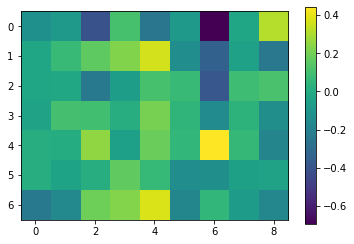

In [15]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

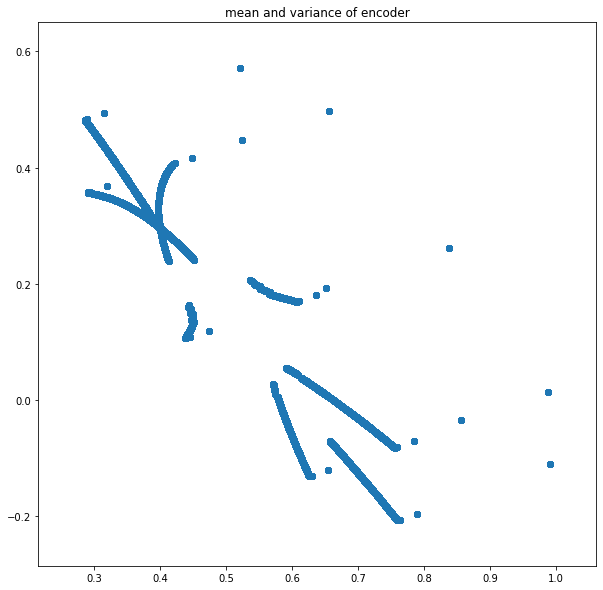

In [16]:
visualize_encoder(decoder)

{'x_min': 0.28558275, 'x_max': 0.9906622, 'y_min': -0.20720378, 'y_max': 0.5724151}


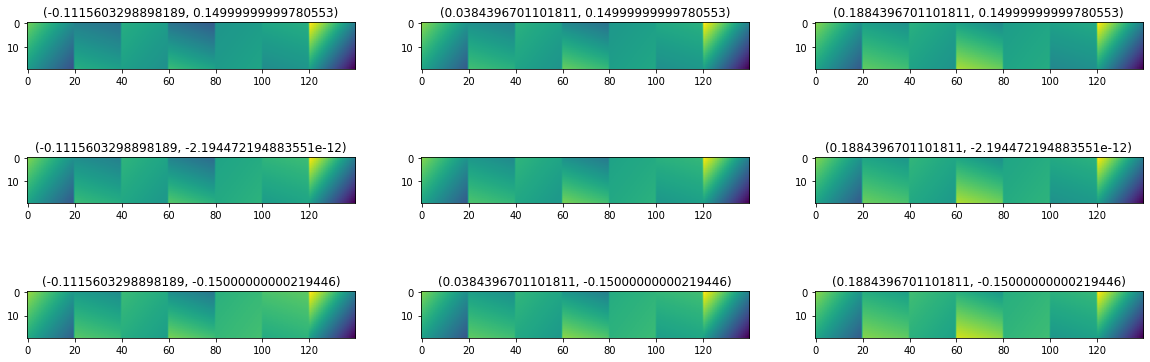

In [17]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

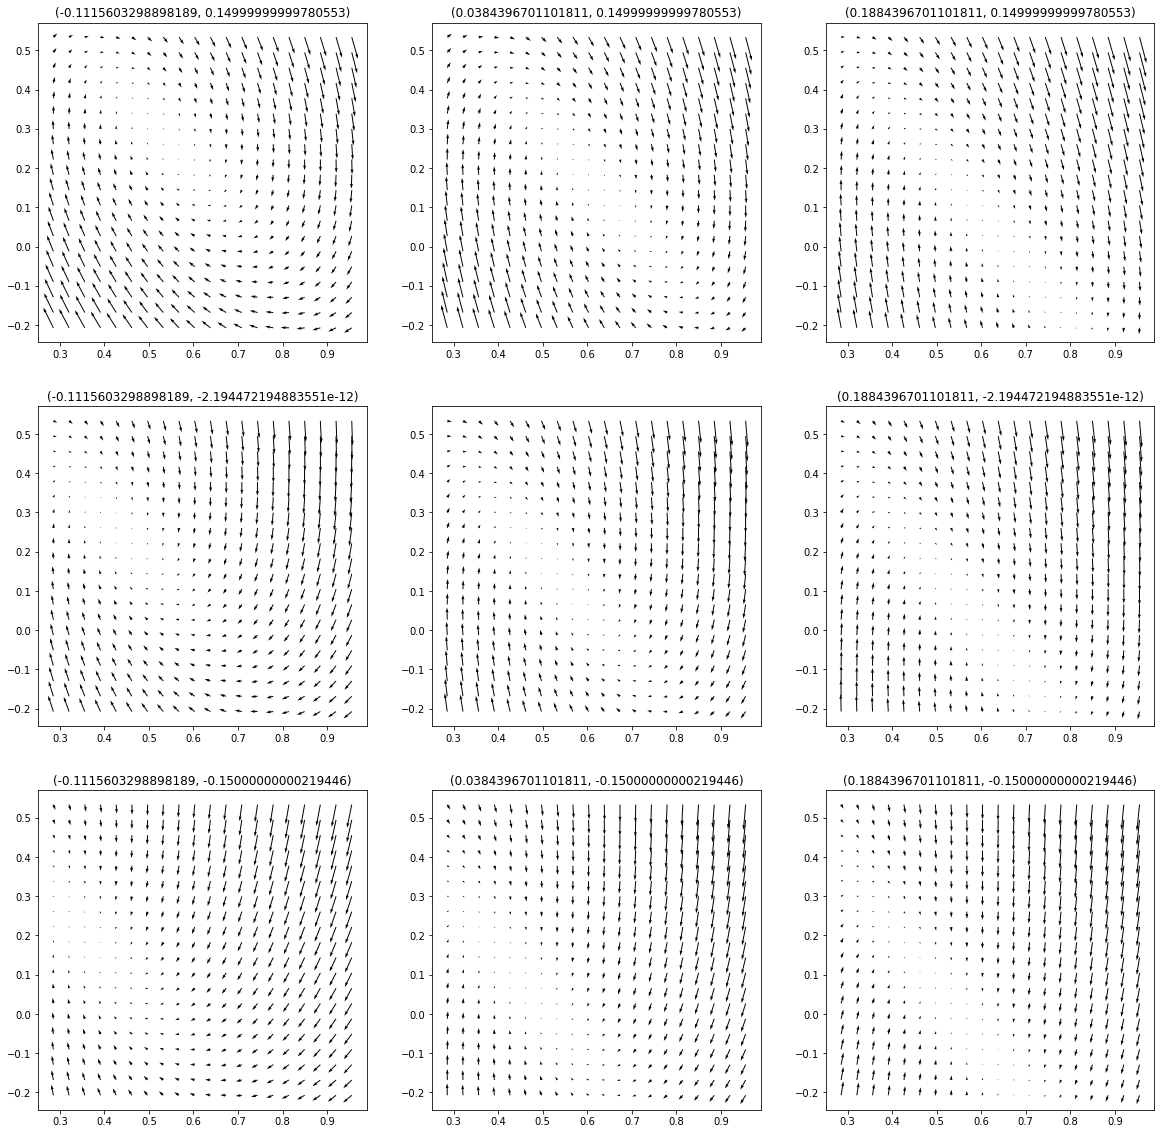

In [18]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

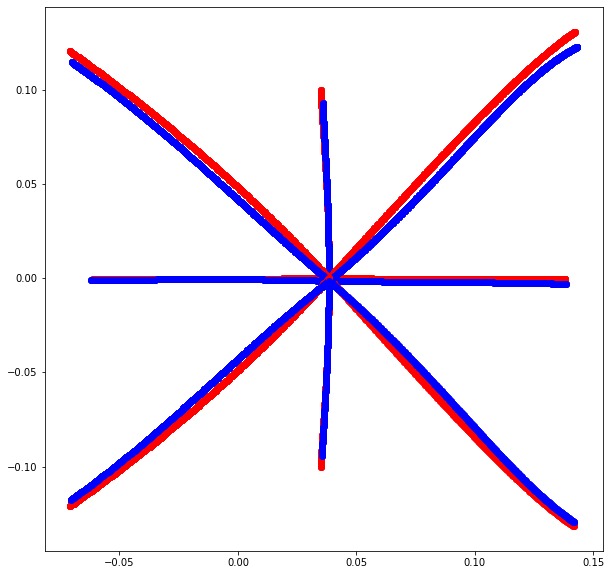

In [19]:
offline_evaluation(decoder)

## honest-dust-476
KL = 0.0001

In [20]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/203f6t2q/checkpoints/epoch=399-step=999999.ckpt')

In [21]:
decoder

ConditionalVAE(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=7, bias=True)
  )
  (fc_mu): Linear(in_features=2, out_features=2, bias=True)
  (fc_var): Linear(in_features=2, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

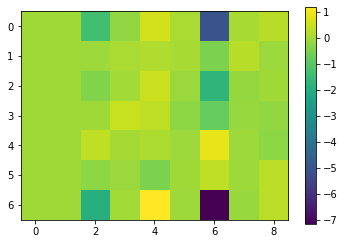

In [22]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

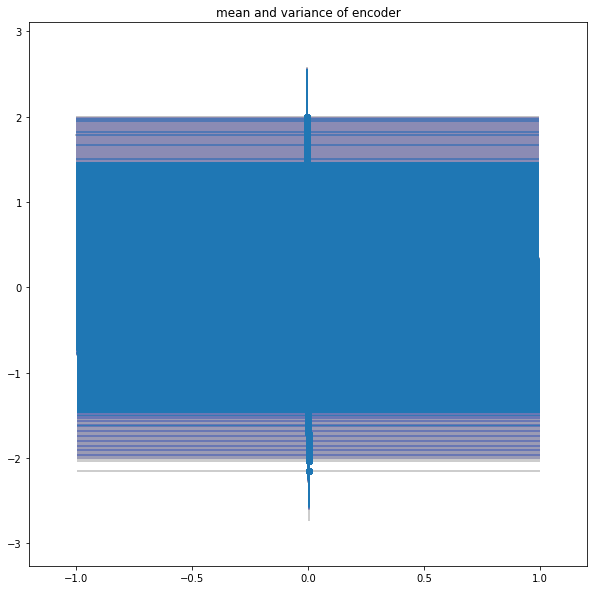

In [23]:
visualize_encoder(decoder)

{'x_min': -1.002859, 'x_max': 1.0021206, 'y_min': -2.7318447, 'y_max': 2.5775633}


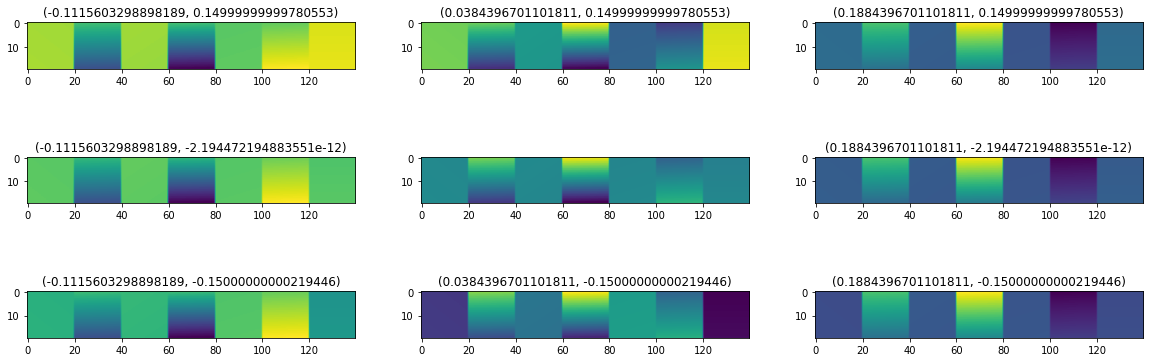

In [24]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

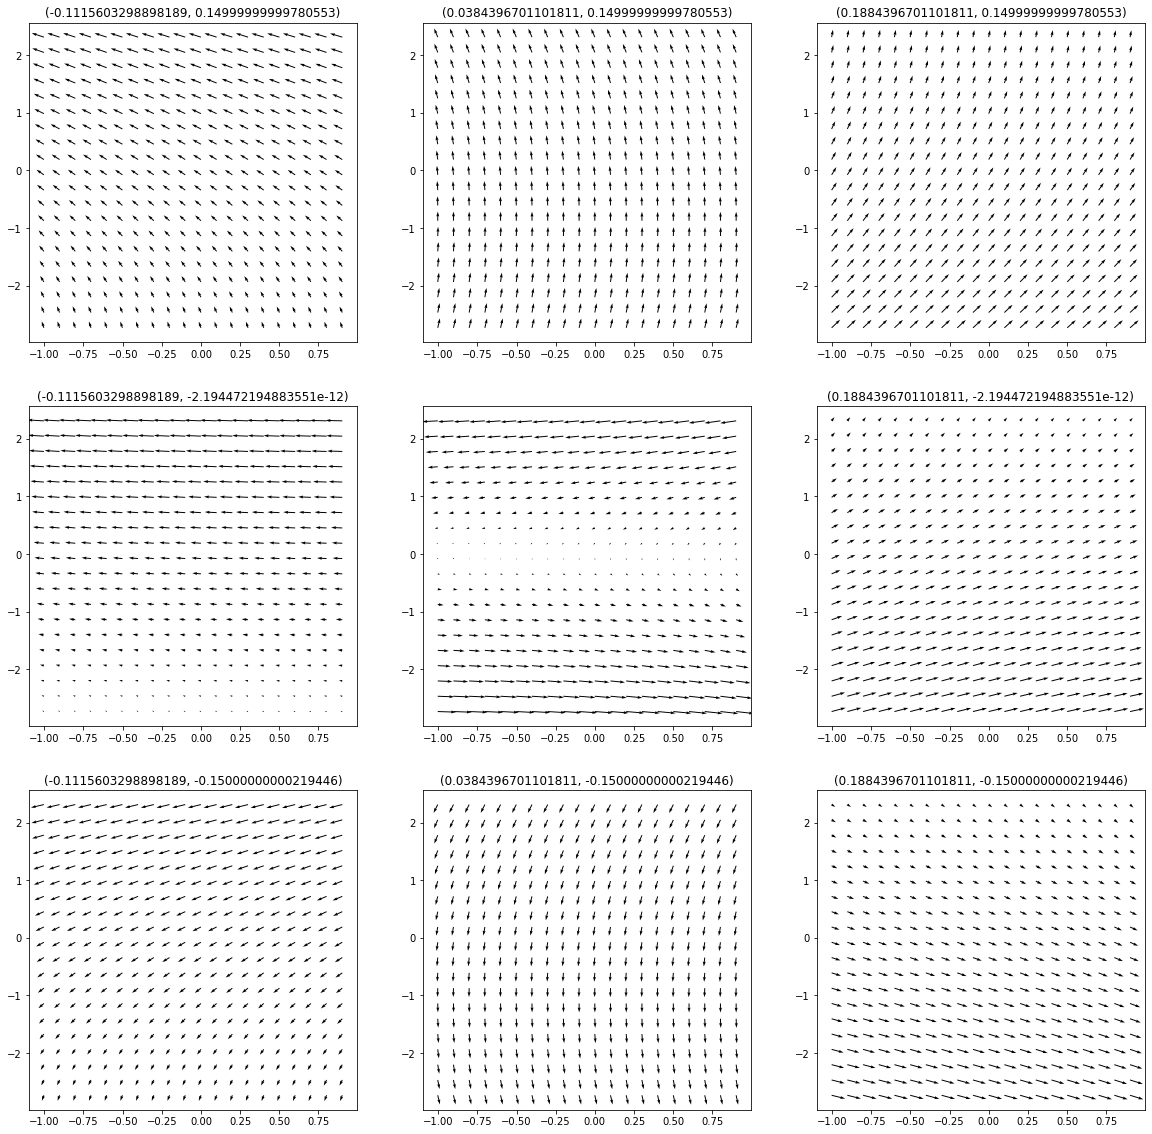

In [25]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

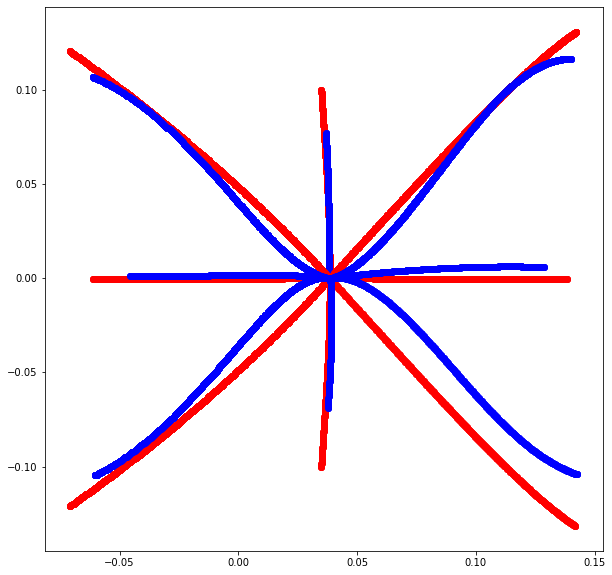

In [26]:
offline_evaluation(decoder)

## logical-pine-475
KL = 0.001

In [27]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/3j94llpt/checkpoints/epoch=399-step=999999.ckpt')

In [28]:
decoder

ConditionalVAE(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=7, bias=True)
  )
  (fc_mu): Linear(in_features=2, out_features=2, bias=True)
  (fc_var): Linear(in_features=2, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

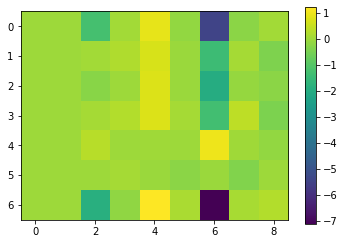

In [29]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

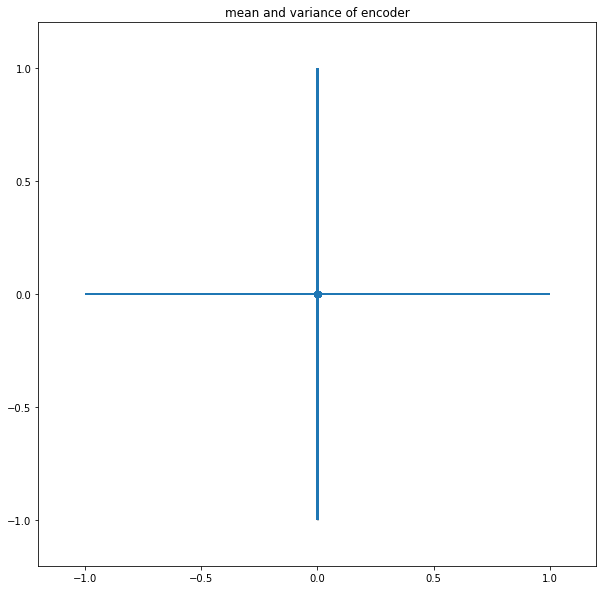

In [30]:
visualize_encoder(decoder)

{'x_min': -1.0000819, 'x_max': 1.0006431, 'y_min': -1.0020022, 'y_max': 1.0006299}


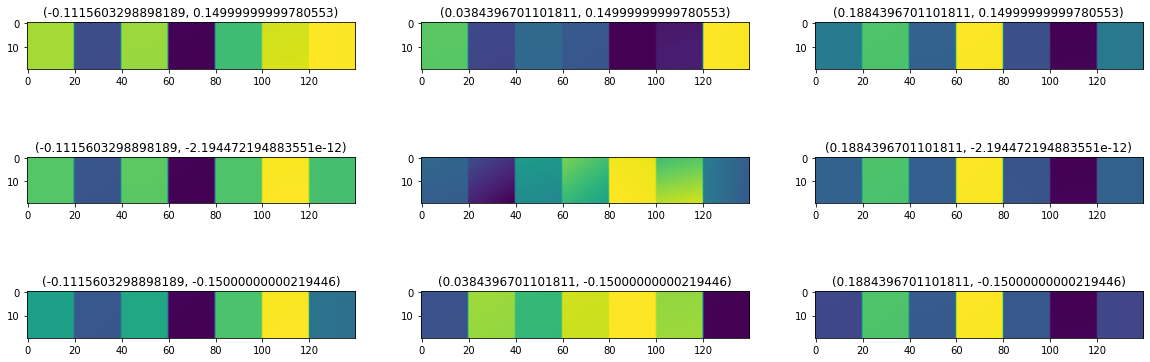

In [31]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

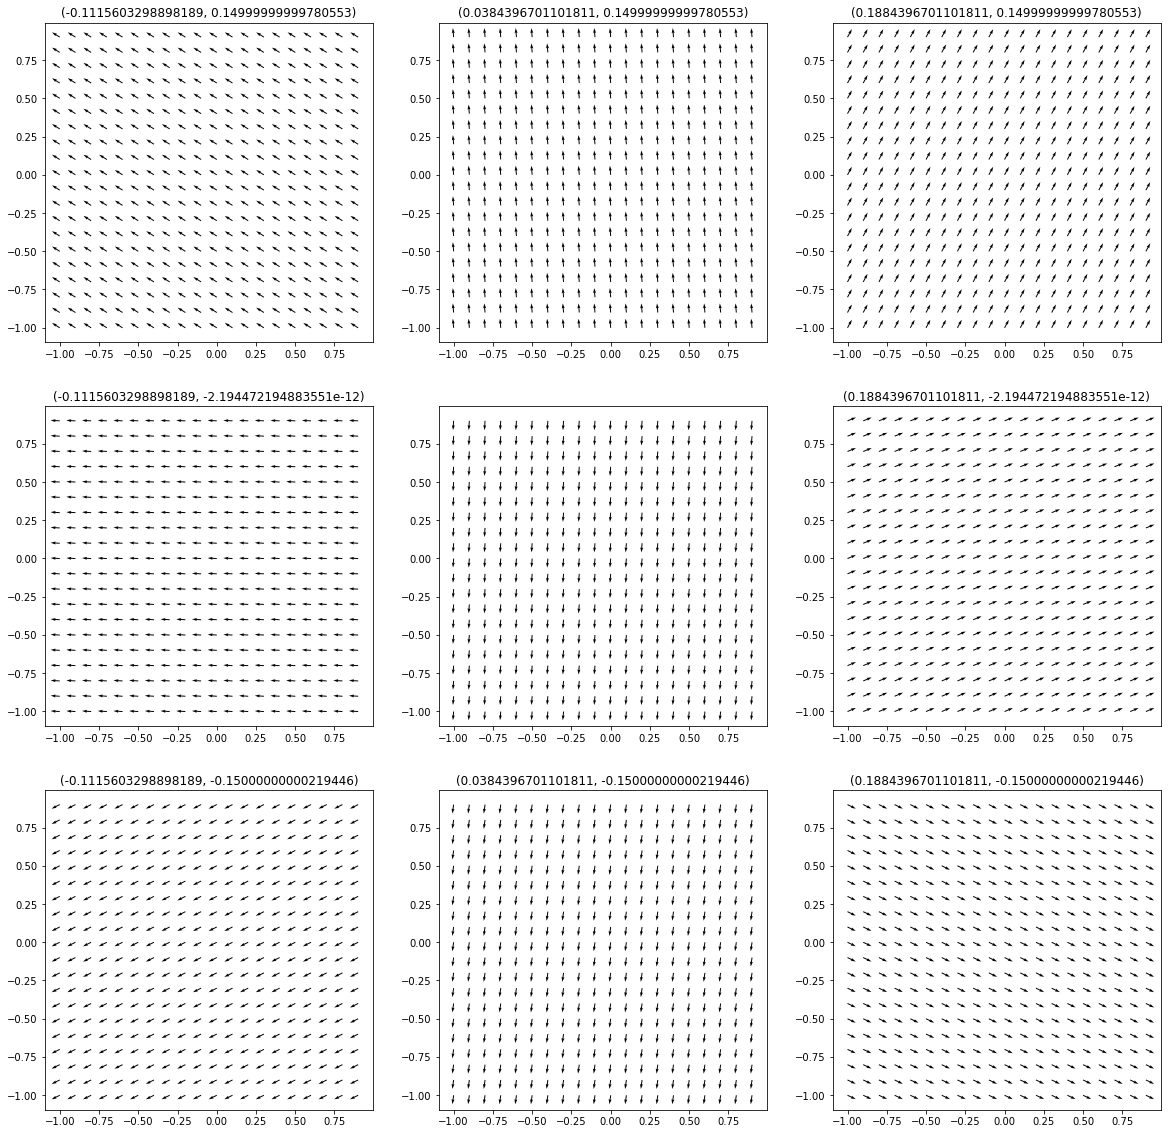

In [32]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

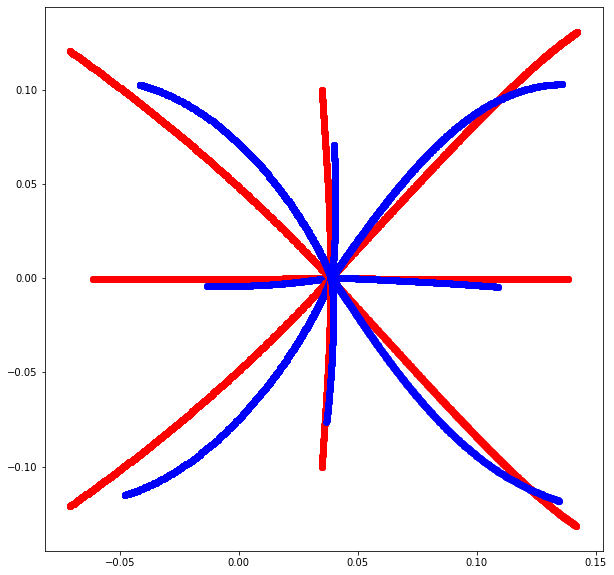

In [33]:
offline_evaluation(decoder)

## absurd-dream-474
KL = 0.01

In [34]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/3l5t1lym/checkpoints/epoch=399-step=999999.ckpt')

In [35]:
decoder

ConditionalVAE(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=7, bias=True)
  )
  (fc_mu): Linear(in_features=2, out_features=2, bias=True)
  (fc_var): Linear(in_features=2, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

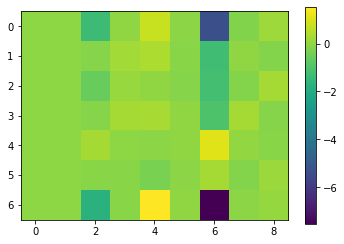

In [36]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

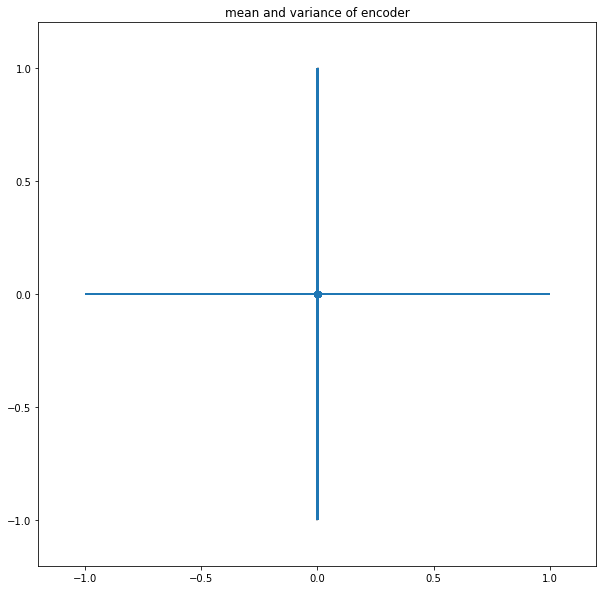

In [37]:
visualize_encoder(decoder)

{'x_min': -1.0005988, 'x_max': 1.00022, 'y_min': -1.0010198, 'y_max': 1.0005132}


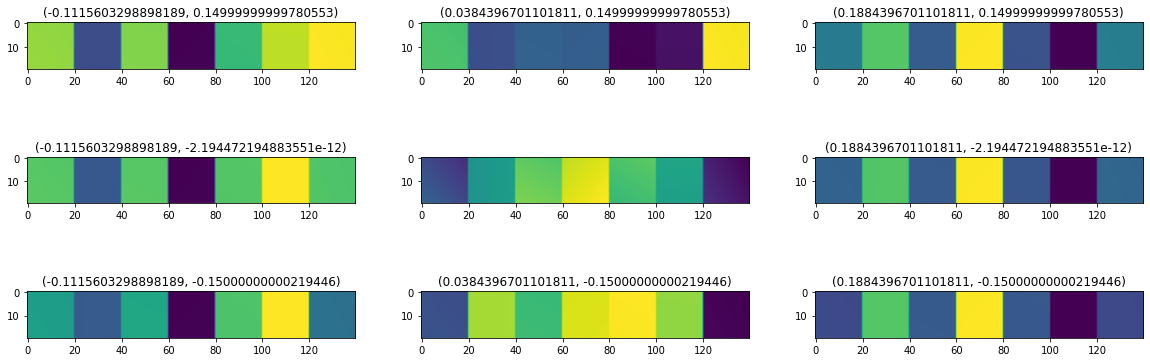

In [38]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

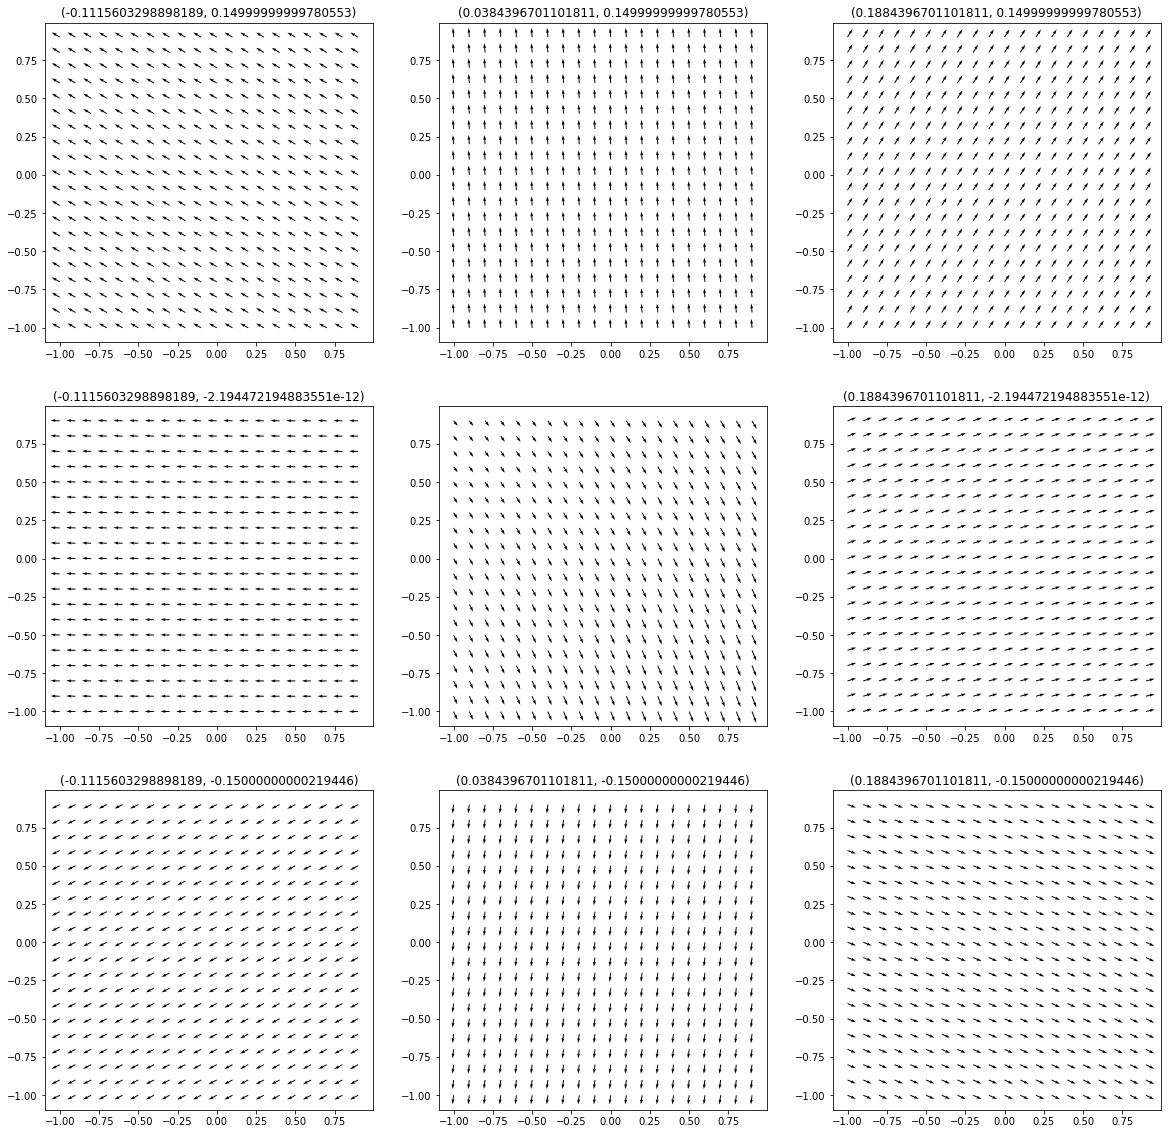

In [39]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

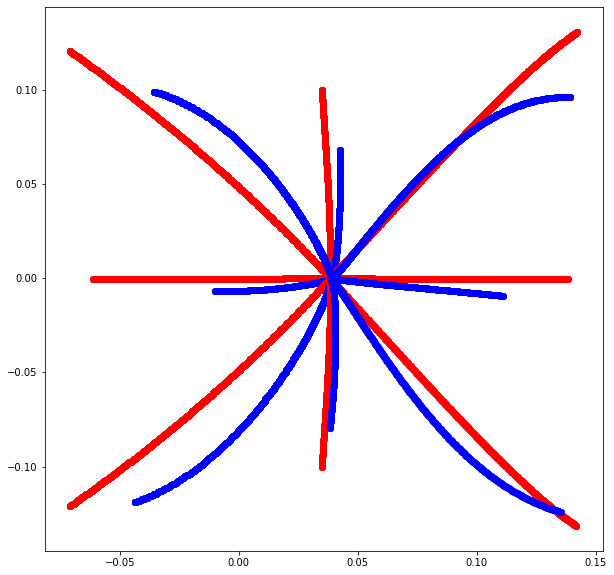

In [40]:
offline_evaluation(decoder)

## honest-snowball-473
KL = 0.1

In [41]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/1451aqep/checkpoints/epoch=399-step=999999.ckpt')

In [42]:
decoder

ConditionalVAE(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=7, bias=True)
  )
  (fc_mu): Linear(in_features=2, out_features=2, bias=True)
  (fc_var): Linear(in_features=2, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

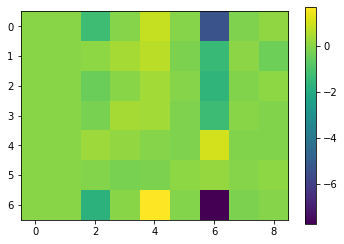

In [43]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

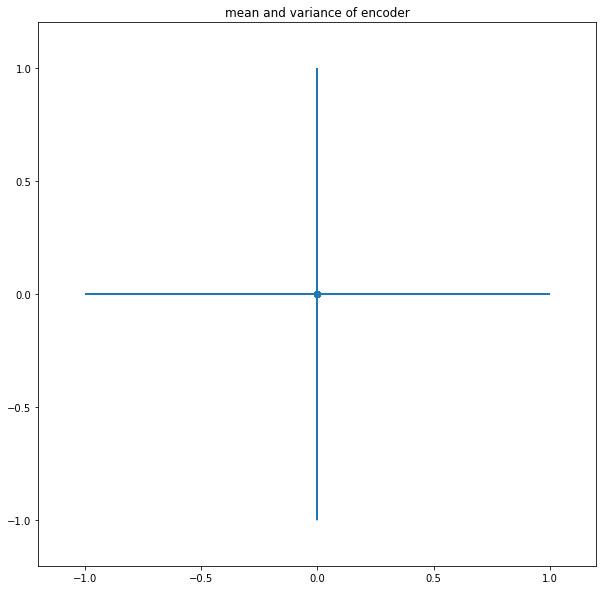

In [44]:
visualize_encoder(decoder)

{'x_min': -1.000278, 'x_max': 1.0000647, 'y_min': -1.0000556, 'y_max': 1.0000839}


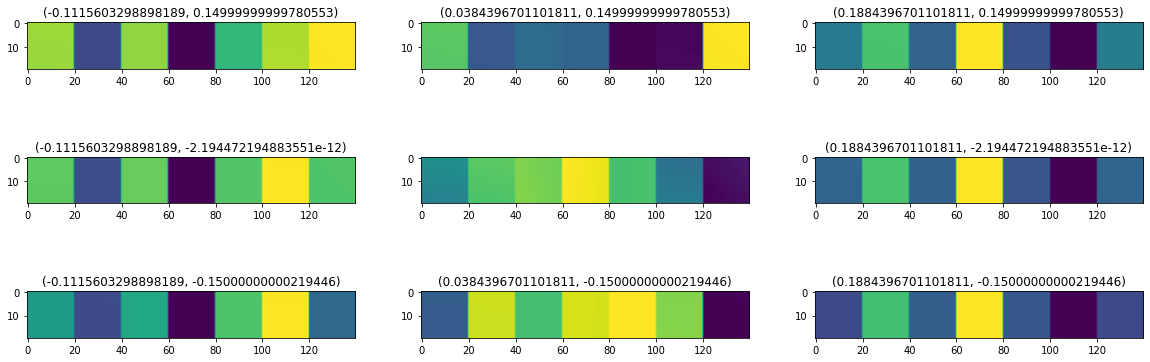

In [45]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

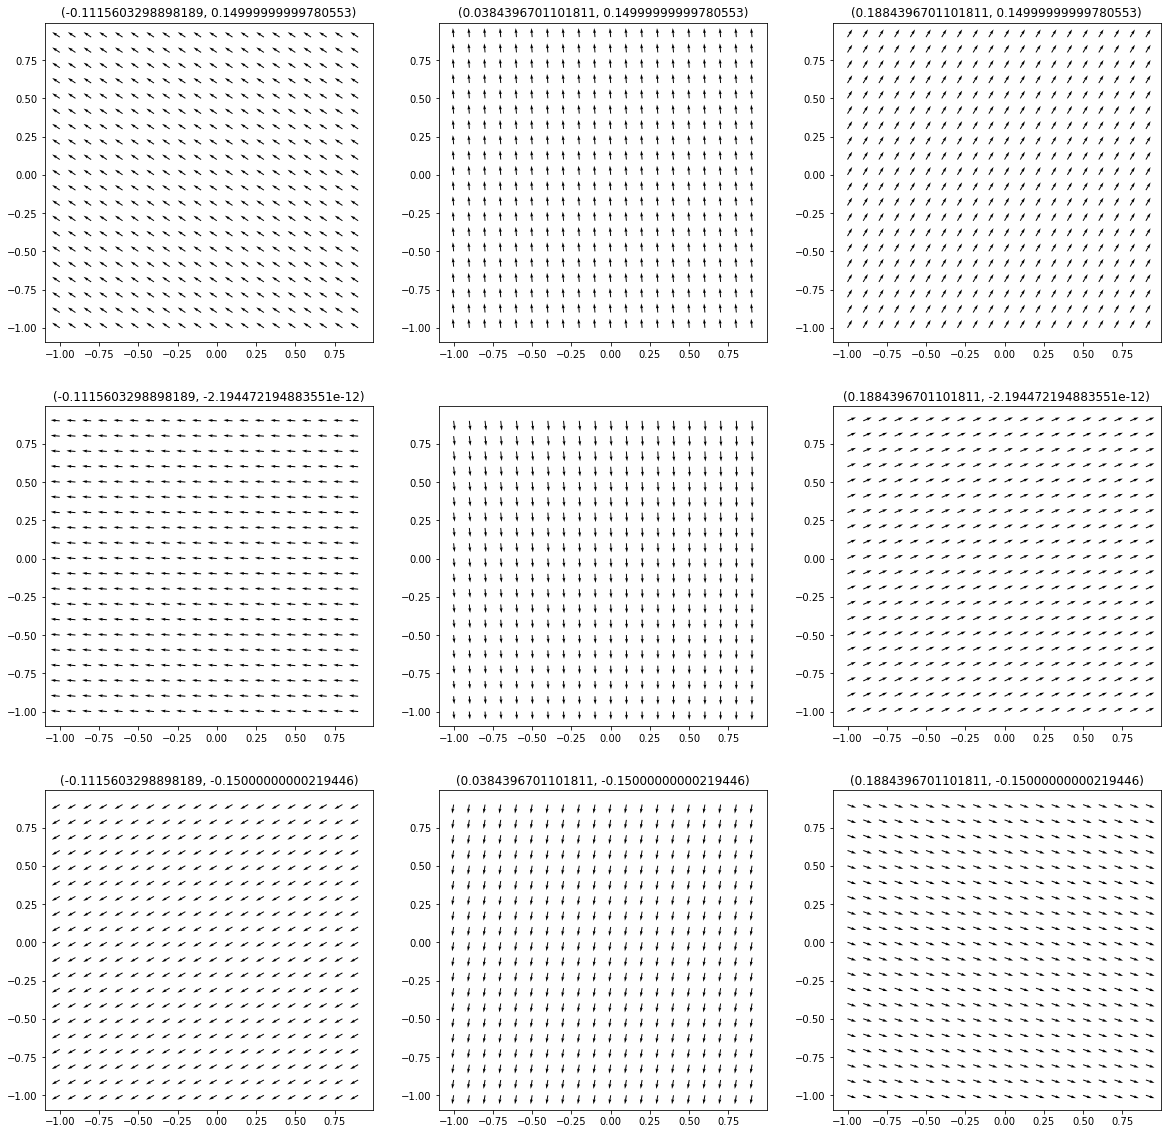

In [46]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

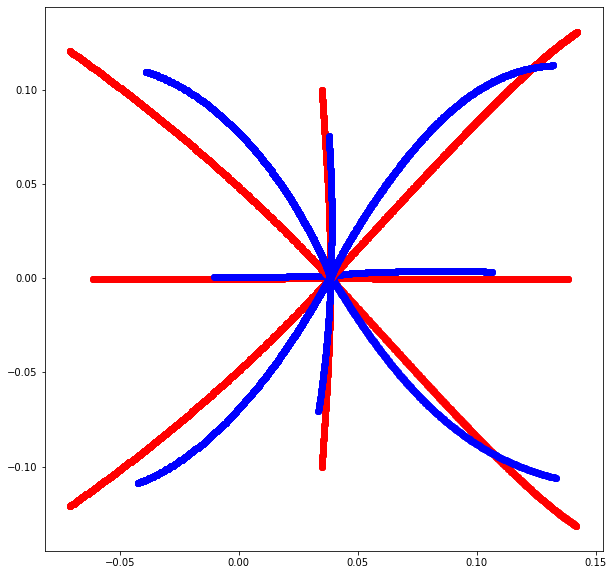

In [47]:
offline_evaluation(decoder)

## sandy-gorge-472
KL = 1

In [48]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/33wqfkyx/checkpoints/epoch=399-step=999999.ckpt')

In [49]:
decoder

ConditionalVAE(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=7, bias=True)
  )
  (fc_mu): Linear(in_features=2, out_features=2, bias=True)
  (fc_var): Linear(in_features=2, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

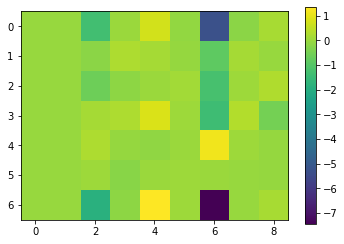

In [50]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

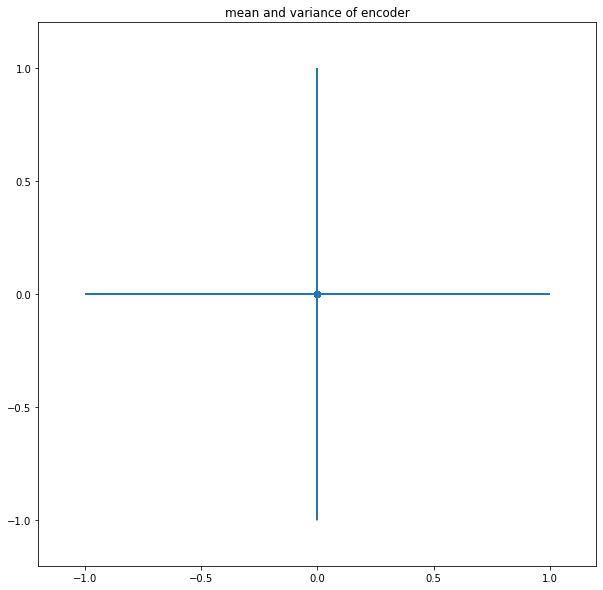

In [51]:
visualize_encoder(decoder)

{'x_min': -1.0001211, 'x_max': 1.000106, 'y_min': -1.0000814, 'y_max': 1.0000893}


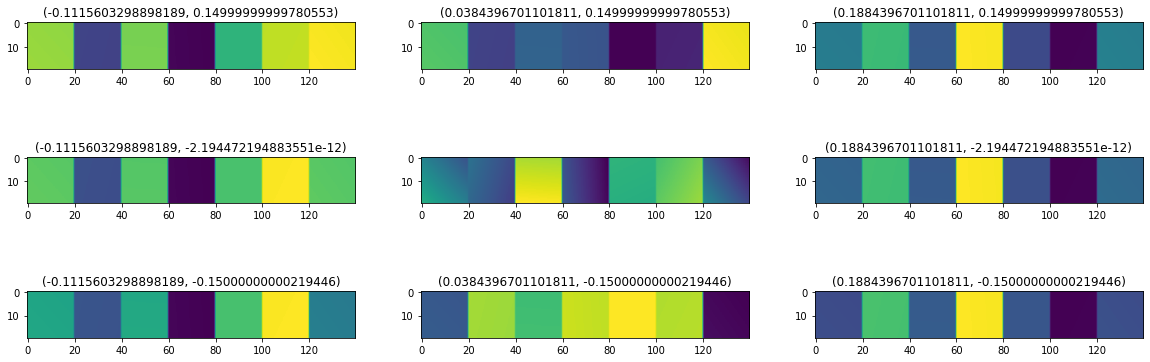

In [52]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

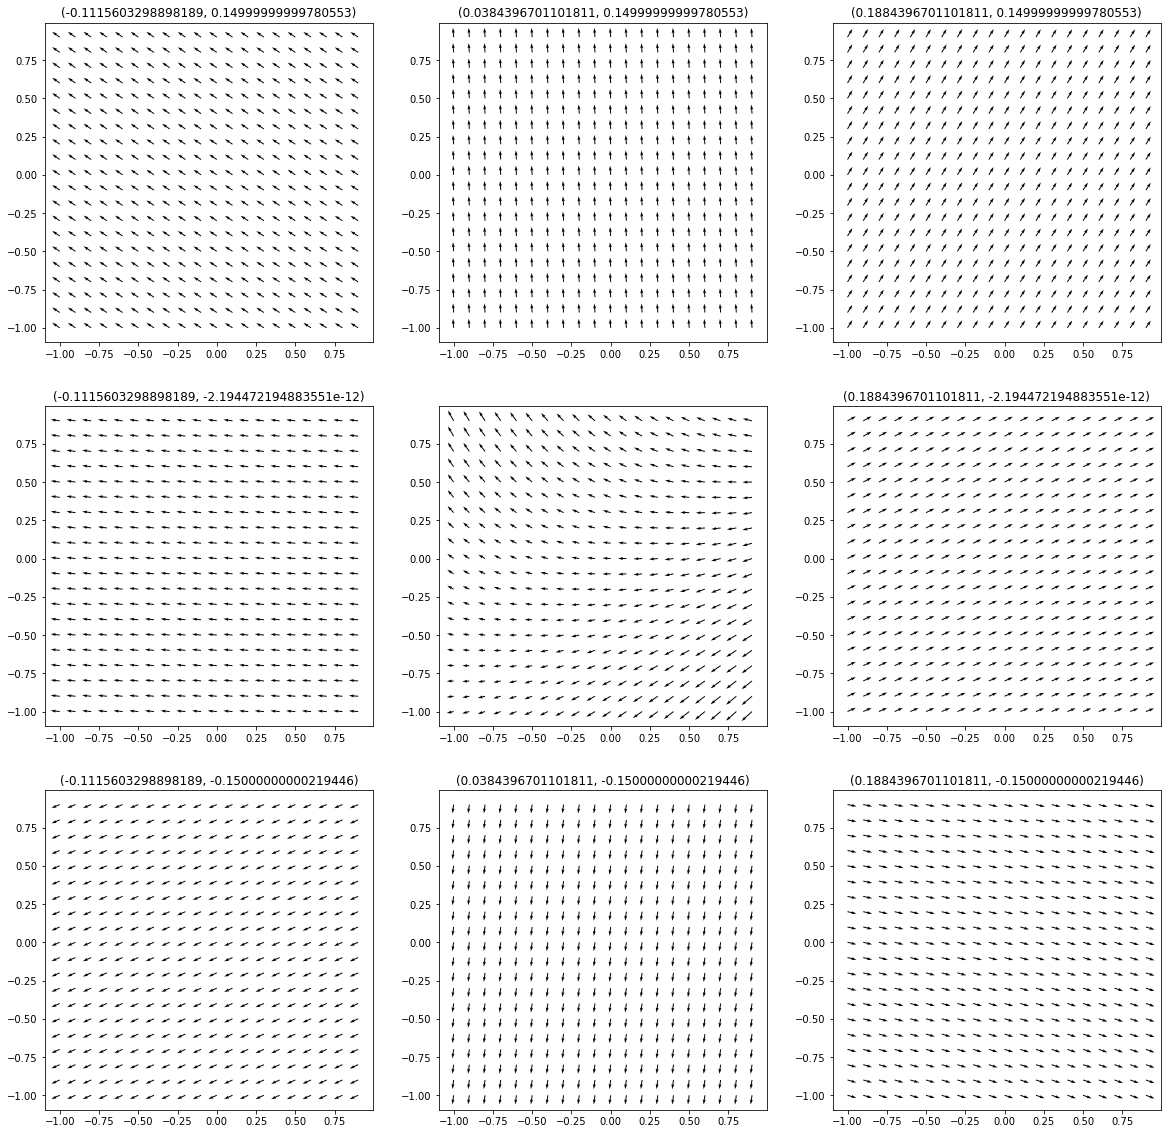

In [53]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

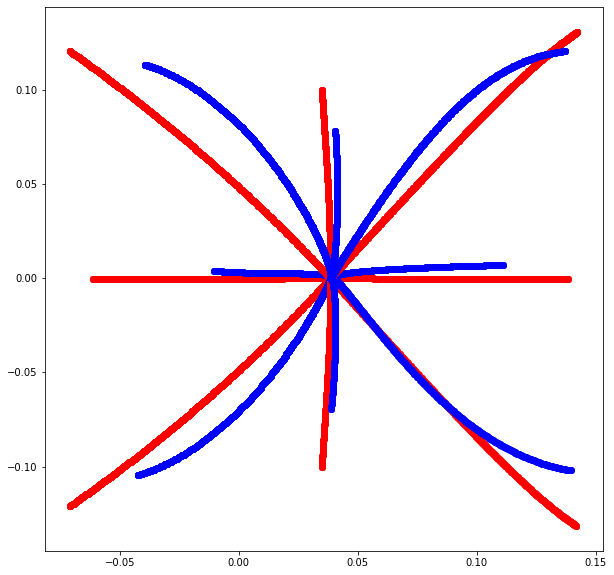

In [54]:
offline_evaluation(decoder)